In [1]:
from openbci_stream.acquisition import Cyton, OpenBCIConsumer
from openbci_stream.acquisition import CytonConstants as cons

from gcpds.utils.filters import GenericButterBand, notch60
from gcpds.utils.processing import welch, fourier

from matplotlib import pyplot as plt
import numpy as np
import time

from gcpds.utils.visualizations import plot_eeg

import logging
logging.getLogger().setLevel(logging.ERROR)
logging.getLogger('kafka').setLevel(logging.ERROR)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

def show(data):
    plt.figure(figsize=(16, 5), dpi=90)

    plt.subplot(121)
    [plt.plot(ch+(i*1e6)-ch.mean()) for (i, ch) in enumerate(data)]
    if len(data)>1:
        plt.yticks(np.arange(len(data))*1e6, [f'ch{ch+1}' for ch in range(len(data))])
    else:
        plt.ylabel('$\mu V$')
    plt.xlim(0, 250)
    plt.xlabel('samples')

    plt.subplot(122)
    # w, Y = welch(data, fs=250, axis=1)
    w, Y = fourier(data, fs=250, axis=1)
    [plt.plot(w, y) for y in Y]
    plt.xlim(0, 90)
    plt.xlabel('Frequency [Hz]')

# Appendix 2 - Measuring Electrode Impedance

The measuring of impedance in the `ADS1299` is made it by injecting a `6nA` altern current at `31.2 Hz`, in this example will be measured the impedande in the `N` inputs (like used for single reference EEG montages), and will be use the `leadoff_impedance` method to set these inputs in the correct mode.

The first step is to connect correctly the Cyton board to replicate this experiment, a `10K` potentiometer will be connected between the `N` input (bottom) of channel 1 and the `SRB2` (bottom), the `BIAS` pin will not be used in this guide, *if you want to test with your head instead of a potentiometer then you must use this pin*.

:::note

  * The impedance measurement [does not work correctly with versions lower to V3.1.2](https://github.com/OpenBCI/OpenBCI_Cyton_Library/issues/94).
  * Is possible to use versions between V3.0.0 and V3.1.2, but you must reset the board every time before measurement and NEVER change the sample frequency.

:::    

## Offline measurement

In [6]:
openbci = Cyton('serial', '/dev/ttyUSB0', capture_stream=True, daisy=False)
openbci.command(cons.DEFAULT_CHANNELS_SETTINGS)
openbci.leadoff_impedance(range(1, 9), pchan=cons.TEST_SIGNAL_NOT_APPLIED, nchan=cons.TEST_SIGNAL_APPLIED)

openbci.stream(7)
data_raw = openbci.eeg_time_series[:, 250:]

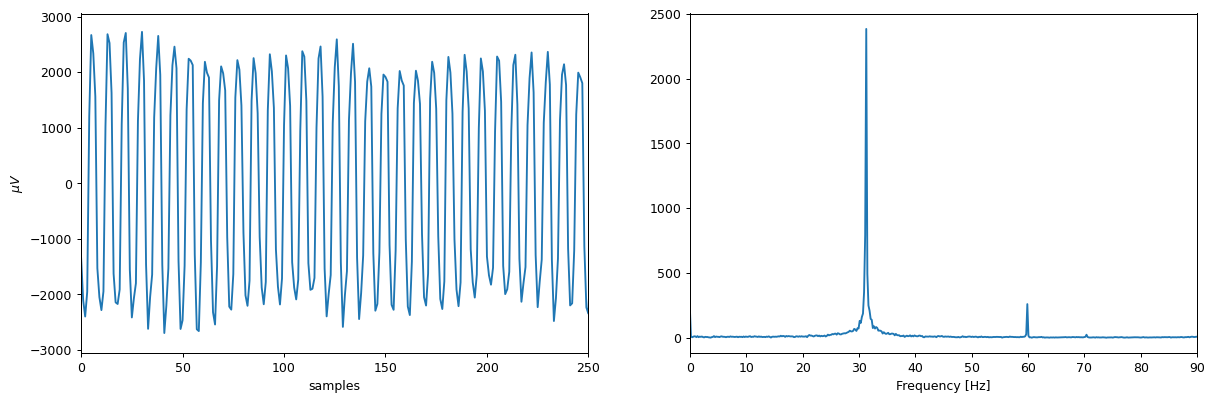

In [7]:
show([data_raw[0]])

We need to have a "perfect" sinusoidal at `31.2 Hz`, so, with a filter:

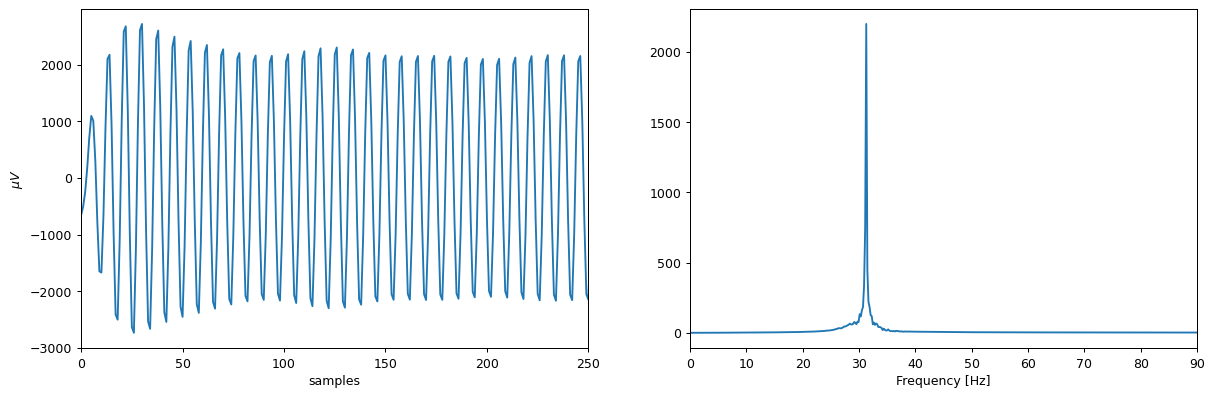

In [8]:
band_2737 = GenericButterBand(27, 37, fs=250)

def filter_impedance(v):
    v = notch60(v, fs=250)
    return band_2737(v, fs=250)

data = filter_impedance(data_raw)
    
show([data[0]])

Now we need the `RMS` voltage, there is a lot of formulas to get this value, even using the `std`, but I like to use one based on the `VPP`:

$$
V_{RMS}=\frac{V_{pp}}{2\sqrt{2}}
$$

Our `Vpp` can be calculated as the *maximun* - *minimum*

In [9]:
def get_rms(v):
    return (v.max()-v.min())/(2*np.sqrt(2))

rms = get_rms(data[0])
rms

1928.0113321346598

$$
Z=\frac{V_{RMS}}{I_{RMS}}
$$

We know that the `ADS1299` injects a `6nA` of alternating current, so:

$$
I_{RMS}=\frac{6nA}{\sqrt{2}}
$$

Then, considering that we have `uV` instaead of `V`:

$$
Z=\frac{\mu V_{RMS}\cdot10^{-6}\cdot\sqrt{2}}{6\cdot10^{-9}}
$$

In [10]:
def get_z(v):
    rms = get_rms(v)
    return 1e-6 * rms * np.sqrt(2) / 6e-9

z = get_z(data[0])
print(f'For {rms:.2f} uVrms the electrode impedance is {z/1000:.2f} KOhm')

For 1928.01 uVrms the electrode impedance is 454.44 KOhm


The Cyton board has a 2.2K Ohm resistors in series with each electrode, so we must remove this value in way to get the real one.

In [11]:
def get_z(v):
    rms = get_rms(v)
    z = (1e-6 * rms * np.sqrt(2) / 6e-9) - 2200
    if z < 0:
        return 0
    return z

z = get_z(data[0])
print(f'For {rms:.2f} uVrms the electrode-to-head impedance is {(z)/1000:.2f} KOhm')

For 1928.01 uVrms the electrode-to-head impedance is 452.24 KOhm


## Real time measurement

For this experiment we will use the Kafka consumer interface, and the same potentiometer.
Keep in mind that this measurement uses 1 second signal, so, the variance will affect the real measure, in real-life the amplitude not change so drastically.

In [18]:
Z = []
with OpenBCIConsumer('serial', '/dev/ttyUSB0', host='localhost', stream_samples=250, daisy=False) as (stream, openbci):
    
    openbci.stop_stream()
    openbci.command(cons.DEFAULT_CHANNELS_SETTINGS)
    openbci.leadoff_impedance(range(1, 9), pchan=cons.TEST_SIGNAL_NOT_APPLIED, nchan=cons.TEST_SIGNAL_APPLIED)
    openbci.start_stream()
    
    for i, message in enumerate(stream):
        if message.topic == 'eeg':
        
            eeg, aux = message.value['data']
            eeg = filter_impedance(eeg)
            z = get_z(eeg[0])
            Z.append(z)
            
            print(f'{z/1000:.2f} kOhm')
            if i > 20:
                break

15.16 kOhm
14.69 kOhm
17.58 kOhm
15.78 kOhm
13.61 kOhm
17.35 kOhm
13.95 kOhm
12.13 kOhm
15.56 kOhm
12.65 kOhm
11.80 kOhm
12.45 kOhm
10.57 kOhm
11.15 kOhm
9.39 kOhm
6.82 kOhm
8.36 kOhm
7.53 kOhm
8.25 kOhm
10.63 kOhm
11.51 kOhm
11.44 kOhm


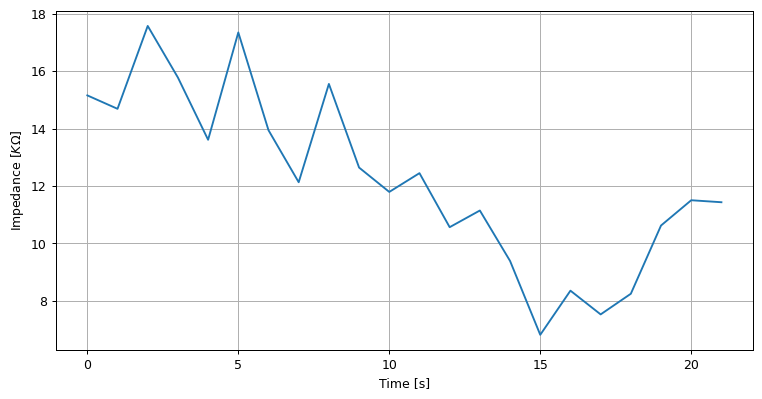

In [19]:
plt.figure(figsize=(10, 5), dpi=90)
plt.plot(np.array(Z)/1000)
plt.ylabel('Impedance [$K\Omega$]')
plt.xlabel('Time [s]')
plt.grid(True)
plt.show()